<a href="https://colab.research.google.com/github/eremeich/hlll_course/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks: Application

## TensorFlow model

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
# from cnn_utils import *

%matplotlib inline
np.random.seed(1)

Data set.................

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
mydataset = unpickle('test_batch')
X = mydataset[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")




In [0]:
# Example of a picture

### Example of a picture

y = 5    b'dog'
b'dog'


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


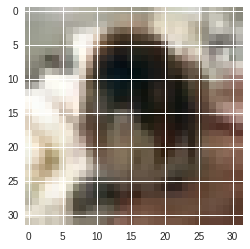

In [0]:
from scipy.misc import toimage
index = 200
plt.imshow(toimage(X[index]))

cathegories = unpickle('/content/gdrive/My Drive/DeepLearningAndNN/DataSets/cifar-10-batches-py/batches.meta')

print ("y = " + str(mydataset[b'labels'][index]) + '    ' + str(cathegories[b'label_names'][mydataset[b'labels'][index]]))

print(str(cathegories[b'label_names'][mydataset[b'labels'][index]]))

In [0]:
from sklearn.model_selection import train_test_split

y = mydataset[b'labels']

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = train_test_split(X, y, test_size=0.2)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = np.array(X_train_orig), np.array(X_test_orig), np.array(Y_train_orig), np.array(Y_test_orig)

print(len(X_train_orig))
print(len(Y_train_orig))
print(len(X_test_orig))
print(len(Y_test_orig))
Y_test_orig

8000
8000
2000
2000


array([7, 9, 3, ..., 1, 2, 8])

In [0]:
classes = list(set(Y_test_orig))
classes.sort()
# classes = np.ndarray(classes)
print(classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Let's examine the shapes of your data...

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
convert_to_one_hot(np.array([9, 3, 8]), 10)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [0]:
list(set(Y_test_orig))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 10).T
Y_test = convert_to_one_hot(Y_test_orig, 10).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 8000
number of test examples = 2000
X_train shape: (8000, 32, 32, 3)
Y_train shape: (8000, 10)
X_test shape: (2000, 32, 32, 3)
Y_test shape: (2000, 10)


## 1.1 - Create placeholders

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ######
    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype=tf.float32)
    Y = tf.placeholder(shape=[None, n_y], dtype=tf.float32)
    ######
    
    return X, Y

In [0]:
X, Y = create_placeholders(32, 32, 3, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 32, 32, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


## 1.2 - Initialize parameters

In [0]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ######
    W1 = tf.get_variable("W", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    ######

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [0]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## 1.2 - Forward propagation

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ######
    # CONV2D: stride of 1, padding 'SAME'
    s = 1
    Z1 = tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    f = s = 8
    P1 = tf.nn.max_pool(A1, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    s = 1
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    f = s = 4
    P2 = tf.nn.max_pool(A2, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # FLATTEN
    F2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(F2, 10, activation_fn=None)
    ######

    return Z3

In [0]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(32, 32, 3, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,32,32,3), Y: np.random.randn(2,10)})
    print("Z3 = " + str(a))

Z3 = [[-0.46206626 -2.3924263   0.81047636 -0.08185682 -1.3921206   0.35634315
   2.679715   -2.4293203   3.9927554   1.7905747 ]
 [-0.6372352  -2.2649157   0.8404879   0.10356474 -1.1271579   0.37392524
   2.4886308  -2.401987    3.542277    1.7610399 ]]


## 1.3 - Compute cost

In [0]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ######
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ######
    
    return cost

In [0]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(32, 32, 3, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,32,32,3), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = 7.187255


## 1.4 Model

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ######
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ######

    # Initialize parameters
    ######
    parameters = initialize_parameters()
    ######
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ######
    Z3 = forward_propagation(X, parameters)
    ######
    
    # Cost function: Add cost function to tensorflow graph
    ######
    cost = compute_cost(Z3, Y)
    ######
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ######
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ######
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ######
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ######
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.239971
Cost after epoch 5: 1.870875
Cost after epoch 10: 1.760377
Cost after epoch 15: 1.703171
Cost after epoch 20: 1.676755
Cost after epoch 25: 1.653339
Cost after epoch 30: 1.637855
Cost after epoch 35: 1.622983
Cost after epoch 40: 1.596592
Cost after epoch 45: 1.590913
Cost after epoch 50: 1.575331
Cost after epoch 55: 1.556916
Cost after epoch 60: 1.556220
Cost after epoch 65: 1.547449
Cost after epoch 70: 1.542465
Cost after epoch 75: 1.545296
Cost after epoch 80: 1.539993
Cost after epoch 85: 1.522745
Cost after epoch 90: 1.521864
Cost after epoch 95: 1.528225


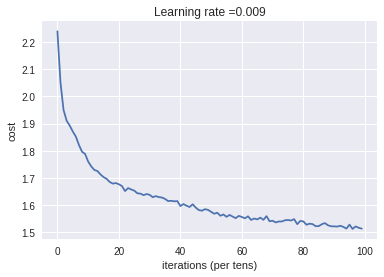

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.43675
Test Accuracy: 0.378


In [0]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)